# Accident severity classification

The dataset, called FARS, is a collection of statistics of US road traffic accidents. The class label (target variable) is about the severity of the accident. It has 20 features and over 100K examples. This pipeline involves exploratory data analysis, data normalisation, feature selection, class imbalance correction, hyperparameter tuning, and testing various combinations and models to achieve best results.


Creating a YData profile report of the whole dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
%matplotlib inline

fars_data = pd.read_csv('fars.csv')
profile = ProfileReport(fars_data, title="FARS Data Profiling Report")
profile.to_file("fars_data_report.html")

/Users/sirderyl/opt/anaconda3/envs/.conda/lib/python3.10/site-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/sirderyl/opt/anaconda3/envs/.conda/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Air_Bag_Available_but_Not_Deployed_for_this_Seat'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Training a simple Random Forest classifier to determine which features the classifier considers important in decision-making. Not all features will be relevant here, especially the highly-imbalanced ones, as the model will consider them important due to bias.

Feature importance before preprocessing:
                                feature  importance
28                                 RACE    0.209611
24                    TAKEN_TO_HOSPITAL    0.162101
1                                   AGE    0.154712
23                      HISPANIC_ORIGIN    0.146437
0                            CASE_STATE    0.079363
13                    ALCOHOL_TEST_TYPE    0.032444
5                  RESTRAINT_SYSTEM-USE    0.026804
6       AIR_BAG_AVAILABILITY/DEPLOYMENT    0.023876
4                      SEATING_POSITION    0.023325
14                  ALCOHOL_TEST_RESULT    0.021165
17              DRUG_TEST_TYPE_(1_of_3)    0.016632
2                                   SEX    0.013964
9                           EXTRICATION    0.013081
18           DRUG_TEST_RESULTS_(1_of_3)    0.012521
11  POLICE_REPORTED_ALCOHOL_INVOLVEMENT    0.011362
7                              EJECTION    0.009032
3                           PERSON_TYPE    0.008298
8                      

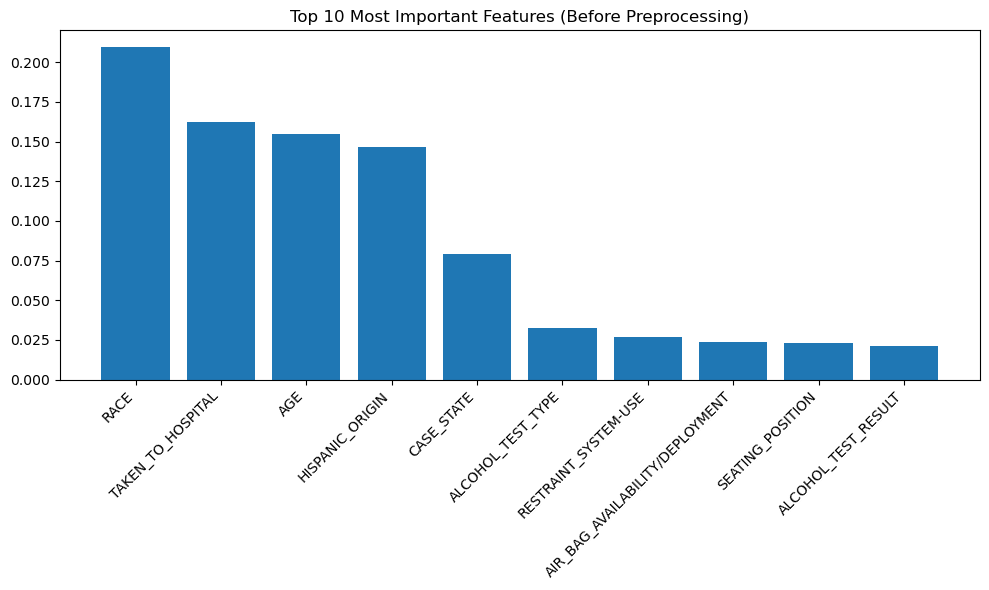

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

original_data = fars_data.copy()

# Encode all categorical variables temporarily for this analysis
categorical_columns = original_data.select_dtypes(include=['object']).columns
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    original_data[column] = label_encoders[column].fit_transform(original_data[column])

# Split features and target class
X_original = original_data.drop('INJURY_SEVERITY', axis=1)
y_original = original_data['INJURY_SEVERITY']

# Random forest train
rf_original = RandomForestClassifier(n_estimators=100)
rf_original.fit(X_original, y_original)

feature_importance_original = pd.DataFrame({
    'feature': X_original.columns,
    'importance': rf_original.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature importance before preprocessing:")
print(feature_importance_original)


plt.figure(figsize=(10, 6))
plt.bar(feature_importance_original['feature'][:10], 
        feature_importance_original['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features (Before Preprocessing)')
plt.tight_layout()
plt.show()

Looking at some of the important variables in more detail, starting with RACE - inspecting its values and their counts. This clearly shows that the RACE variable is only considered important because the majority of the samples are "Not a Fatality (Not Applicable)", creating a significant bias. Also, there are a lot of missing values labeled as "Unknown".

RACE
Not_a_Fatality_(Not_Applicable)                               58686
White                                                         19582
Unknown                                                       18336
Black                                                          3392
American_Indian_(_Includes_Aleuts_and_Eskimos)                  436
Filipino                                                        103
All_Other_Races                                                  99
Other_Asian_or_Pacific_Islander                                  65
Chinese                                                          42
Vietnamese                                                       40
Asian_Indian                                                     37
Hawaiian_(Includes_part-Hawaiian)                                36
Asian_or_Pacific_Islander_No_Specific_(Individual)_Race          35
Korean                                                           27
Japanese                                   

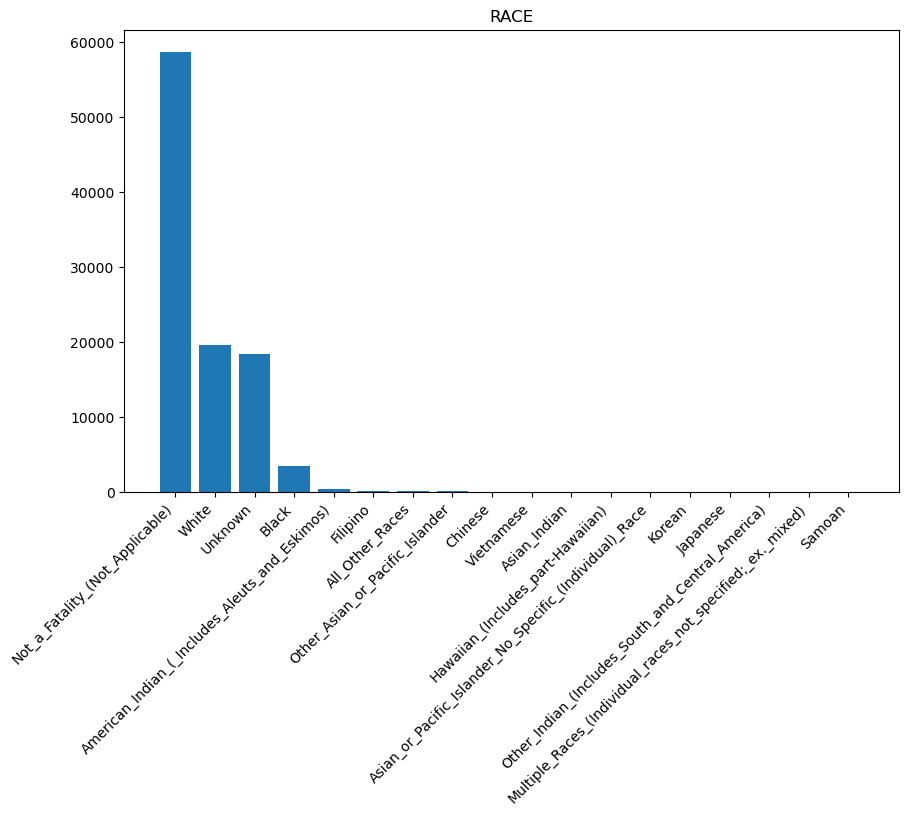

In [3]:
print(fars_data['RACE'].value_counts())

plt.figure(figsize=(10, 6))
plt.bar(fars_data['RACE'].value_counts().index, fars_data['RACE'].value_counts().values)
plt.xticks(rotation=45, ha='right')
plt.title('RACE')
plt.show()

Inspecting TAKEN_TO_HOSPITAL - unlike RACE, this is a high-quality variable containing valuable information for the model. However, it still has a few Unknown (missing) values. These can be imputed so TAKEN_TO_HOSPITAL becomes a binary variable

TAKEN_TO_HOSPITAL
Yes        52355
No         46699
Unknown     1914
Name: count, dtype: int64


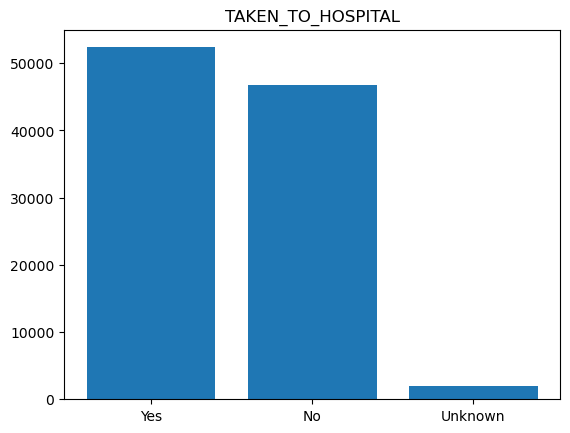

In [4]:
print(fars_data['TAKEN_TO_HOSPITAL'].value_counts())

plt.figure()
plt.bar(fars_data['TAKEN_TO_HOSPITAL'].value_counts().index, fars_data['TAKEN_TO_HOSPITAL'].value_counts().values)
plt.title('TAKEN_TO_HOSPITAL')
plt.show()

Removing highly imbalanced variables and variables with a large portion of meaningless values, such as 'not applicable', 'not reported', or 'unknown':

<span style='color:green'>**RELATED FACTOR - PERSON LEVEL**</span> - imbalanced, removing all three of these variables as the level of imbalance is above 90% for each of these, majority of values being "Not Applicable"

<span style='color:green'>**NON MOTORIST LOCATION**</span> - imbalanced, majority of values being "Not Applicable", level of imbalance 87.2%

<span style='color:green'>**EJECTION PATH**</span> - imbalanced, majority of values being "Not Applicable" and "Unknown", level of imbalance 77.2%

<span style='color:green'>**METHOD ALCOHOL DETERMINATION**</span> - imbalanced, majority of values being "Not Reported"

<span style='color:green'>**METHOD OF DRUG DETERMINATION**</span> - imbalanced, majority of values being "Not Reported"

<span style='color:green'>**DRUG TEST TYPE**</span> - imbalanced, all three variables having the majority of values as "Not Tested for Drugs". The first drug test type is removed later in the notebook file as it is used for analysis in combination with drug results

<span style='color:green'>**HISPANIC ORIGIN**</span> - imbalanced, majority of values being "Not a Fatality (Not Applicable) + a lot of "Unkown" values, adding no valuable information

<span style='color:green'>**RACE**</span> - imbalanced, similar situation to "HISPANIC ORIGIN"

<span style='color:green'>**CASE STATE**</span> - Contains 51 unique values, that's too many values to learn from. Tried mapping each state to a region, resulting in 4 unique values - Northeast, South, Midwest, and West. Even though the CASE_STATE appears as an important variable at the beginning, it is not nearly as important for the model after data preprocessing

<span style='color:green'>**SEATING POSITION**</span> - after reducing the number of categories by mapping the values to "first row", "second row" etc. I discovered that this variable is highly correlated with PERSON TYPE, adding no new valuable information to the data

P.S. More variables will be dropped further down as either needed for further analysis or discovering their low importance later

In [5]:
cols_to_drop = ['RELATED_FACTOR_(1)-PERSON_LEVEL',
                'RELATED_FACTOR_(2)-PERSON_LEVEL',
                'RELATED_FACTOR_(3)-PERSON_LEVEL',
                'NON_MOTORIST_LOCATION',
                'EJECTION_PATH',
                'METHOD_ALCOHOL_DETERMINATION',
                'METHOD_OF_DRUG_DETERMINATION',
                'DRUG_TEST_TYPE_(2_of_3)',
                'DRUG_TEST_TYPE_(3_of_3)',
                'HISPANIC_ORIGIN',
                'RACE',
                'CASE_STATE',
                'SEATING_POSITION'
                ]

fars_data = fars_data.drop(cols_to_drop, axis=1)

There are multiple variables indicating alcohol involvement in the accident. This is not helpful for the model, so my aim is to create a single variable that will determine whether alchohol was involved.

Let's start by examining the alcohol test results in more detail

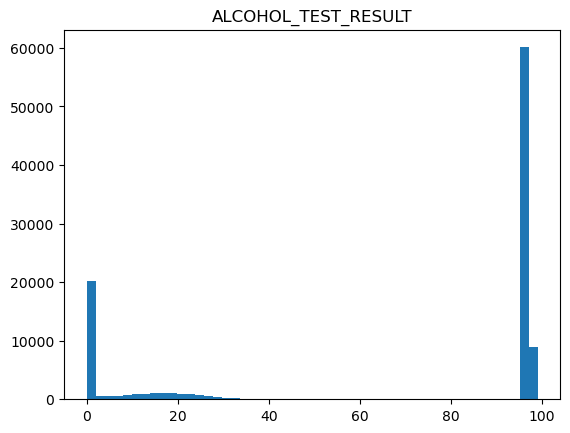

In [6]:
plt.figure()
plt.hist(fars_data['ALCOHOL_TEST_RESULT'], bins=50)
plt.title('ALCOHOL_TEST_RESULT')
plt.show()

In [7]:
print(fars_data['ALCOHOL_TEST_RESULT'].value_counts())

ALCOHOL_TEST_RESULT
96    55316
0     19798
99     8991
97     4797
16      590
      ...  
71        1
81        1
76        1
57        1
66        1
Name: count, Length: 69, dtype: int64


Strangely, the most frequent value here is 96, being almost 55% of the whole distribution. However, inspecting few of the rows where the test result value is 96 in combination with the police report makes this a bit clearer.

In [8]:
print(fars_data[fars_data['ALCOHOL_TEST_RESULT'] == 96][['ALCOHOL_TEST_RESULT', 'POLICE_REPORTED_ALCOHOL_INVOLVEMENT']].head(50))

    ALCOHOL_TEST_RESULT POLICE_REPORTED_ALCOHOL_INVOLVEMENT
1                    96           No_(Alcohol_Not_Involved)
2                    96           No_(Alcohol_Not_Involved)
3                    96                        Not_reported
5                    96           No_(Alcohol_Not_Involved)
6                    96           No_(Alcohol_Not_Involved)
10                   96           No_(Alcohol_Not_Involved)
12                   96           No_(Alcohol_Not_Involved)
13                   96           No_(Alcohol_Not_Involved)
15                   96                        Not_reported
18                   96           No_(Alcohol_Not_Involved)
19                   96                        Not_reported
20                   96           No_(Alcohol_Not_Involved)
27                   96                        Not_reported
28                   96                        Not_reported
29                   96           No_(Alcohol_Not_Involved)
31                   96                 

For a lot of rows with a test result of 96, there are corresponding police reports that state there was no alcohol involved, which shouldn't be the case for such a high number. Additionally, the total count of rows with alcohol test result of 96 is 55316. In ALCOHOL_TEST_TYPE, the total count of "Not tested for alcohol" values is 55405. This indicates that the number 96 was likely used for alcohol tests that were not taken. Therefore, this number in the test result shouldn't be used in determining the alcohol involvement.

In [9]:
print(fars_data[fars_data['ALCOHOL_TEST_RESULT'] == 96]['ALCOHOL_TEST_RESULT'].value_counts())
print()
print(fars_data[fars_data['ALCOHOL_TEST_TYPE'] == 'Not_Tested_for_Alcohol']['ALCOHOL_TEST_TYPE'].value_counts())

ALCOHOL_TEST_RESULT
96    55316
Name: count, dtype: int64

ALCOHOL_TEST_TYPE
Not_Tested_for_Alcohol    55405
Name: count, dtype: int64


Dropping ALCOHOL_TEST_TYPE as have no further use for it + it is highly imbalanced

In [10]:
fars_data = fars_data.drop(columns=['ALCOHOL_TEST_TYPE'], axis=1)

As POLICE_REPORTED_ALCOHOL_INVOLVEMENT has a lot of "Not reported" or "Unknown" values, I will attempt to combine the information from the police report and alcohol test results to reduce the number of missing samples.

Further examining the connection between ALCOHOL_TEST_RESULT and POLICE_REPORTED_ALCOHOL_INVOLVEMENT:

In [11]:
# Printing the total count of values that have both test result of 0 and police report of unknown
# The values can be changed to examine other combinations
print(fars_data[
    (fars_data['ALCOHOL_TEST_RESULT'] == 0) & 
    (fars_data['POLICE_REPORTED_ALCOHOL_INVOLVEMENT'] == 'Unknown_(Police_Reported)')
][['POLICE_REPORTED_ALCOHOL_INVOLVEMENT']].count())

POLICE_REPORTED_ALCOHOL_INVOLVEMENT    4177
dtype: int64


Comparing some of the alcohol test values to the police report values reveals that for almost any test result, there are occurences where the police report states either "Yes" or "No". Therefore, the alcohol test results aren't 100% reliable, but I can compare the number of "Yes" values to the number of "No" values from the police report for each of the test results to determine how much the test result value matches the police report and how likely is the test result value to be associated with positive alcohol involvement.

Test result value 0 has considerably more occurences of "No" values from police reports than "Yes", therefore this value is safe to use for determining that alcohol vas not involved.

Value 1 has 99x "Yes" from the police report and 89x "No". This could be due to a small margin of error/tolerance and makes it unclear whether value 1 is associated with positive alcohol involvement. Therefore, value 1 will be left as "unknown" in the alcohol involved variable that is to be created later.

Value 2 has 128x "Yes" from the police report and 44x "No". That is a larger margin than value 1. Even though it is still not high enough for a confident decision, the probability of value 2 being associated with positive alcohol involvement is significantly higher than with value 1. Additionally, as the test result value increases, the margin between "Yes" and "No" from the police report also increases, therefore I will consider values 2 and above (up until 95) as if there was alcohol involved.

Values 95 and above (96 being used for "not tested" as explined earlier) mostly have more "No" from police report than "Yes", therefore I will treat them as inconsistent and not include those in determining alcohol involvement.

--

Using police report as the ground truth for alcohol involvement and substituting some unknowns using the alcohol test results according to the above findings

In [12]:
def determine_alcohol_involvement(row):
    # First check police report
    if row['POLICE_REPORTED_ALCOHOL_INVOLVEMENT'] == 'Yes_(Alcohol_Involved)':
        return 1
    elif row['POLICE_REPORTED_ALCOHOL_INVOLVEMENT'] == 'No_(Alcohol_Not_Involved)':
        return 0
    else:   # Not reported or unknown
        # Use alcohol test result as secondary evidence according to the findings
        if row['ALCOHOL_TEST_RESULT'] == 0:
            return 0
        elif row['ALCOHOL_TEST_RESULT'] > 1 and row['ALCOHOL_TEST_RESULT'] < 95:
            return 1
        else:
            return -1   # Unknown values

Creating a new ALCOHOL_INVOLVED variable indicating alcohol involvement using 0 as not involved, 1 as involved, and -1 as unknown. Dropping the other remaining alcohol variables.

In [13]:
fars_data['ALCOHOL_INVOLVED'] = fars_data.apply(determine_alcohol_involvement, axis=1)
fars_data = fars_data.drop(['ALCOHOL_TEST_RESULT', 'POLICE_REPORTED_ALCOHOL_INVOLVEMENT'], axis=1)

print(fars_data['ALCOHOL_INVOLVED'].value_counts())

ALCOHOL_INVOLVED
 0    43405
-1    43241
 1    14322
Name: count, dtype: int64


Drug involvement also has multiple variables. Ideally, we should also be left with a single drug variable indicating drug involvement. However, here the police report is less useful as the majority of the values are "Not reported"

In [14]:
print(fars_data['POLICE-REPORTED_DRUG_INVOLVEMENT'].value_counts())

POLICE-REPORTED_DRUG_INVOLVEMENT
Not_Reported        74725
No_Drugs            18335
Reported_Unknown     6282
Drugs_Involved       1626
Name: count, dtype: int64


I will attempt to reduce the number of "Not reported" and "Reported unknown" by using values from the drug test results.

For the drug tests, each test has exactly the same amount of 0 values as their corresponding "Not tested for drugs" value in DRUG_TEST_TYPE, so it is safe to assume value 0 corresponds to "not tested" rather than "no drug involved".

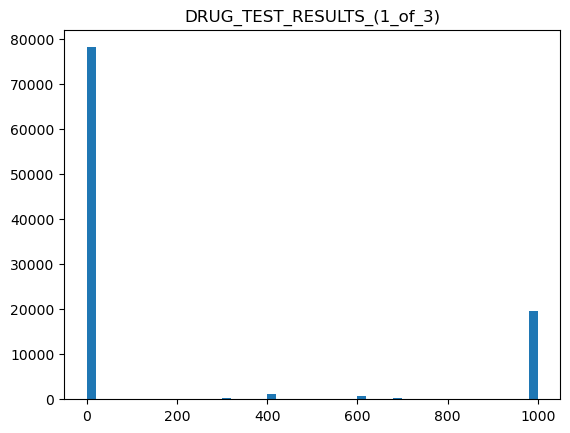

In [15]:
plt.figure()
plt.hist(fars_data['DRUG_TEST_RESULTS_(1_of_3)'], bins=50)
plt.title('DRUG_TEST_RESULTS_(1_of_3)')
plt.show()

In [16]:
print(fars_data[fars_data['DRUG_TEST_RESULTS_(1_of_3)'] == 0]['DRUG_TEST_RESULTS_(1_of_3)'].value_counts())
print()
print(fars_data[fars_data['DRUG_TEST_TYPE_(1_of_3)'] == 'Not_Tested_for_Drugs']['DRUG_TEST_TYPE_(1_of_3)'].value_counts())
fars_data = fars_data.drop(['DRUG_TEST_TYPE_(1_of_3)'], axis=1)

DRUG_TEST_RESULTS_(1_of_3)
0    64072
Name: count, dtype: int64

DRUG_TEST_TYPE_(1_of_3)
Not_Tested_for_Drugs    64072
Name: count, dtype: int64


Both the values 0 and Not tested for drugs have 64072 samples

--

Inspecting the relationship between drug test results and police reports:

Value 999 has significantly more "No drugs" than "Drugs involved" from the police report, but that may also be due to the significantly lower representation of "Drugs involved" samples. Also, the number of sampled for 999 matches the number of "Unknown if tested for drugs" samples in the drug test type, therefore the value 999 is most likely used for "unknown if tested for drugs" and I will not consider this value in determining drug involvement.

Value 0 count corresponds to "not tested" count, will not include in determining drug involvement.

Value 1 has significantly more samples with "No drugs" in the police report than "Drugs involved", which could be due to under-representation of "Drugs involved" samples, but also due to a small margin of error when taking the test. I will consider this value as "no drug" when determining drug involvement.

In [17]:
# Printing the total count of values that have both test result of 1 and police report of drugs involved
# The values can be changed to examine other combinations
print(fars_data[
    (fars_data['DRUG_TEST_RESULTS_(1_of_3)'] == 1) & 
    (fars_data['POLICE-REPORTED_DRUG_INVOLVEMENT'] == 'Drugs_Involved')
][['POLICE-REPORTED_DRUG_INVOLVEMENT']].count())

POLICE-REPORTED_DRUG_INVOLVEMENT    273
dtype: int64


Using police report as the ground truth for drug involvement and substituting some unknowns using the test results according to the above findings

In [18]:
def determine_drug_involvement(row):
    # First check police report
    if row['POLICE-REPORTED_DRUG_INVOLVEMENT'] == 'Drugs_Involved':
        return 1
    elif row['POLICE-REPORTED_DRUG_INVOLVEMENT'] == 'No_Drugs':
        return 0
    else:   # Not reported or unknown
        # Use drug test result as secondary evidence according to the findings
        if (
            row['DRUG_TEST_RESULTS_(1_of_3)'] == 1 and
            row['DRUG_TEST_RESULTS_(2_of_3)'] == 1 and
            row['DRUG_TEST_RESULTS_(3_of_3)'] == 1
        ):
            return 0
        elif (
            row['DRUG_TEST_RESULTS_(1_of_3)'] > 1 and
            row['DRUG_TEST_RESULTS_(1_of_3)'] < 999 and
            row['DRUG_TEST_RESULTS_(2_of_3)'] > 1 and
            row['DRUG_TEST_RESULTS_(2_of_3)'] < 999 and
            row['DRUG_TEST_RESULTS_(3_of_3)'] > 1 and
            row['DRUG_TEST_RESULTS_(3_of_3)'] < 999
        ):
            return 1
        else:
            return -1   # Unknown values

Creating a new variable DRUG_INVOLVED, indicating drug involvement and dropping the other remaining drug variables. Using 0 as "no drug", 1 as "drug involved", and -1 as "unknown". Printing the DRUG_INVOLVED distribution

In [19]:
fars_data['DRUG_INVOLVED'] = fars_data.apply(determine_drug_involvement, axis=1)

cols_to_drop = ['DRUG_TEST_RESULTS_(1_of_3)',
                'DRUG_TEST_RESULTS_(2_of_3)',
                'DRUG_TEST_RESULTS_(3_of_3)',
                'POLICE-REPORTED_DRUG_INVOLVEMENT'
                ]

fars_data = fars_data.drop(cols_to_drop, axis=1)

print(fars_data['DRUG_INVOLVED'].value_counts())

DRUG_INVOLVED
-1    80030
 0    18893
 1     2045
Name: count, dtype: int64


This results in 80030 unknown samples, which is still the majority and therefore not useful for training. I will drop this variable and not use any drug-related variable in predicting injury severity

In [20]:
fars_data = fars_data.drop(['DRUG_INVOLVED'], axis=1)

Inspecting the AGE variable in more detail, we find out an unusually high amount of samples with age of 99, compared to the rest if the enclosing values.

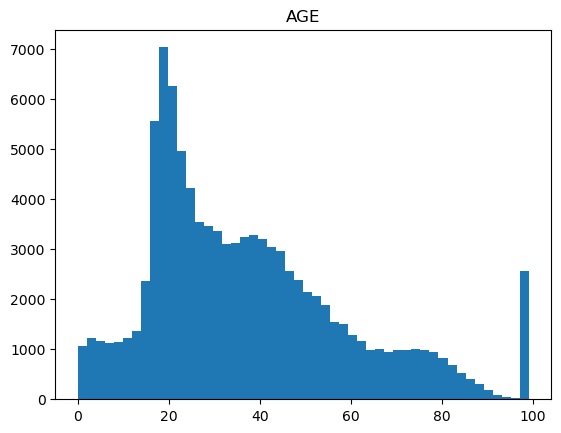

In [21]:
plt.figure()
plt.hist(fars_data['AGE'], bins=50)
plt.title('AGE')
plt.show()

The sample below shows that some of the rows where the age of the person is 99, they were also a driver, which is unlikely. This suggests that the age 99 was used as a value determining cases where the age was unknown, or something similar. Therefore this value should be either discarded or imputed into the distribution using the mean value.

In [22]:
print(fars_data[fars_data['AGE'] == 99][['AGE', 'PERSON_TYPE']].head(20))

     AGE                                PERSON_TYPE
78    99                                     Driver
81    99  Passenger_of_a_Motor_Vehicle_in_Transport
115   99  Passenger_of_a_Motor_Vehicle_in_Transport
126   99  Passenger_of_a_Motor_Vehicle_in_Transport
127   99  Passenger_of_a_Motor_Vehicle_in_Transport
141   99                                     Driver
148   99  Passenger_of_a_Motor_Vehicle_in_Transport
153   99                                     Driver
170   99  Passenger_of_a_Motor_Vehicle_in_Transport
171   99  Passenger_of_a_Motor_Vehicle_in_Transport
256   99  Passenger_of_a_Motor_Vehicle_in_Transport
282   99  Passenger_of_a_Motor_Vehicle_in_Transport
313   99  Passenger_of_a_Motor_Vehicle_in_Transport
314   99  Passenger_of_a_Motor_Vehicle_in_Transport
404   99                                     Driver
415   99  Passenger_of_a_Motor_Vehicle_in_Transport
423   99  Passenger_of_a_Motor_Vehicle_in_Transport
428   99  Passenger_of_a_Motor_Vehicle_in_Transport
429   99  Pa

Imputing the age 99 with mean

In [23]:
mean_age = fars_data[fars_data['AGE'] != 99]['AGE'].mean()
fars_data['AGE'] = fars_data['AGE'].replace(99, mean_age)

Checking the distribution to verify that the age 99 is no longer present. Showing as a bar plot here as histogram was creating a weird artifact where the samples around the range of 25-35 would show a significant drop, even though that is not the case

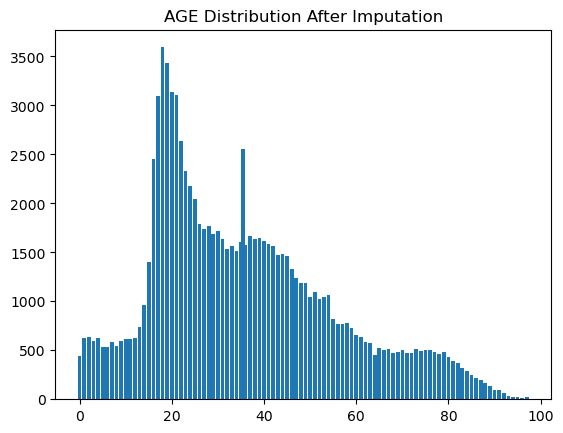

In [24]:
plt.figure()
plt.bar(fars_data['AGE'].value_counts().index, fars_data['AGE'].value_counts().values)
plt.title('AGE Distribution After Imputation')
plt.show()

RESTRAINT_SYSTEM-USE - this variable has a lot of unique values and almost 9% of them being Unknown

In [25]:
# Check distribution of RESTRAINT_SYSTEM-USE
print("RESTRAINT_SYSTEM-USE distribution:")
print(fars_data['RESTRAINT_SYSTEM-USE'].value_counts())
print(f"\nPercentage of unknown values: {(fars_data['RESTRAINT_SYSTEM-USE'] == 'Unknown').mean()*100:.2f}%")

RESTRAINT_SYSTEM-USE distribution:
RESTRAINT_SYSTEM-USE
None_Used/Not_Applicable             41462
Lap_and_Shoulder_Belt                40763
Unknown                               9017
Restraint_Used_-_Type_Unknown         2973
Lap_Belt                              2523
Motorcycle_Helmet                     1898
Child_Safety_Seat                     1542
Shoulder_Belt                          470
Safety_Belt_Used_Improperly            131
Child_Safety_Seat_Used_Improperly       73
Bicycle_Helmet                          60
Helmets_Used_Improperly                 56
Name: count, dtype: int64

Percentage of unknown values: 8.93%


This can be condensed to a simple binary variable stating whether any type of restraint was used

In [26]:
# Creating a binary feature for restraint system use
def get_restraint_used(value):
    # No restraint used or used improperly
    if value in ['None_Used/Not_Applicable',
                 'Safety_Belt_Used_Improperly',
                 'Child_Safety_Seat_Used_Improperly',
                 'Helmets_Used_Improperly']:
        return 0
    # Restraint used properly
    elif value in ['Lap_and_Shoulder_Belt',
                   'Restraint_Used_-_Type_Unknown',
                   'Lap_Belt',
                   'Motorcycle_Helmet',
                   'Child_Safety_Seat',
                   'Shoulder_Belt',
                   'Bicycle_Helmet']:
        return 1
    # Unknown cases (will deal with them later)
    else:
        return -1

Creating a new RESTRAINT_USED varialbe and checking the distribution. The number of unknown values is 9017, which should be safe to impute

In [27]:
fars_data['RESTRAINT_USED'] = fars_data['RESTRAINT_SYSTEM-USE'].apply(get_restraint_used)

# Check distribution including unknowns
print("Distribution of RESTRAINT_USED:")
print(fars_data['RESTRAINT_USED'].value_counts())

Distribution of RESTRAINT_USED:
RESTRAINT_USED
 1    50229
 0    41722
-1     9017
Name: count, dtype: int64


Using the mode to impute the unknown values - tested the model's performance both while keeping the unknown values and with imputing them using mode and the results were very similar.

In [28]:
mode_value = fars_data[fars_data['RESTRAINT_USED'] != -1]['RESTRAINT_USED'].mode()[0]
fars_data['RESTRAINT_USED'] = fars_data['RESTRAINT_USED'].replace(-1, mode_value)
fars_data = fars_data.drop('RESTRAINT_SYSTEM-USE', axis=1)
print(fars_data['RESTRAINT_USED'].value_counts())

RESTRAINT_USED
1    59246
0    41722
Name: count, dtype: int64


Imputing unknown values in SEX using the mode value as they only make around 1.6%

In [29]:
print("Distribution of SEX:")
print(fars_data['SEX'].value_counts())
print(f"\nPercentage of unknown values: {(fars_data['SEX'] == 'Unknown').mean()*100:.2f}%")

mode_value = fars_data[fars_data['SEX'] != 'Unknown']['SEX'].mode()[0]
fars_data['SEX'] = fars_data['SEX'].replace('Unknown', mode_value)

print("\nDistribution after imputation:")
print(fars_data['SEX'].value_counts())

Distribution of SEX:
SEX
Male       65740
Female     33573
Unknown     1655
Name: count, dtype: int64

Percentage of unknown values: 1.64%

Distribution after imputation:
SEX
Male      67395
Female    33573
Name: count, dtype: int64


Converting to binary variable - 0 for "Male", 1 for "Female"

In [30]:
fars_data['SEX'] = (fars_data['SEX'] == 'Female').astype(int)
print(fars_data['SEX'].value_counts())

SEX
0    67395
1    33573
Name: count, dtype: int64


Unnecessarilly, the PERSON_TYPE variable has quite a lot of values. Grouping some of them to combine similar categories reduces the number of values by half

In [31]:
print("Distribution of PERSON_TYPE:")
print(fars_data['PERSON_TYPE'].value_counts())

person_type_mapping = {
    'Driver': 'Driver',
    'Passenger_of_a_Motor_Vehicle_in_Transport': 'Passenger',
    'Pedestrian': 'Pedestrian',
    'Bicyclist': 'Cyclist',
    'Occupant_of_a_Motor_Vehicle_Not_in_Transport': 'Passenger',
    'Unknown_Occupant_Type_in_a_Motor_Vehicle_in_Transport': 'Passenger',
    'Other_Pedestrian': 'Pedestrian',
    'Occupant_of_a_Non-Motor_Vehicle_Transport_Device': 'Other',
    'Other_Cyclist': 'Cyclist',
    'Unknown_Type_of_Non-Motorist': 'Other'
}

fars_data['PERSON_TYPE'] = fars_data['PERSON_TYPE'].map(person_type_mapping)

Distribution of PERSON_TYPE:
PERSON_TYPE
Driver                                                   57480
Passenger_of_a_Motor_Vehicle_in_Transport                36812
Pedestrian                                                5331
Bicyclist                                                  744
Unknown_Occupant_Type_in_a_Motor_Vehicle_in_Transport      234
Occupant_of_a_Motor_Vehicle_Not_in_Transport               225
Other_Pedestrian                                           103
Occupant_of_a_Non-Motor_Vehicle_Transport_Device            34
Other_Cyclist                                                3
Unknown_Type_of_Non-Motorist                                 2
Name: count, dtype: int64


In [32]:
print(fars_data['PERSON_TYPE'].value_counts())

PERSON_TYPE
Driver        57480
Passenger     37271
Pedestrian     5434
Cyclist         747
Other            36
Name: count, dtype: int64


AIR_BAG_AVAILABILITY/DEPLOYMENT also has a lot of values. It would be more beneficial and easier for the model to learn if this was a binary variable determining whether airbag has been deployed

In [33]:
print("Distribution of AIR_BAG_AVAILABILITY/DEPLOYMENT:")
print(fars_data['AIR_BAG_AVAILABILITY/DEPLOYMENT'].value_counts())

Distribution of AIR_BAG_AVAILABILITY/DEPLOYMENT:
AIR_BAG_AVAILABILITY/DEPLOYMENT
Air_Bag_Not_Available_for_this_Seat                     58738
Deployed_Air_Bag_from_Front                             15136
Air_Bag_Available_but_Not_Deployed_for_this_Seat         9455
Air_Bad_Available-Deployment_Not_Known_for_this_Seat     7555
Non-Motorist                                             6442
Unknown_(If_Airbag_Available)                            3260
Deployed_Air_Bag_Multiple_Directions                      147
Deployed_Air_Bag_from_Side                                108
Deployed_Air_Bag_Direction_Unknown                         60
Air_Bag_Available_and_Switched_Off                         28
Air_Bag_Disabled_or_Removed                                22
Air_Bag_Previously_Deployed_and_not_Replaced               14
Deployed_Air_Bag_Other_Direction                            3
Name: count, dtype: int64


Mapping all the values to either "No_Airbag", "Deployed" or "Unknown" first

In [34]:
airbag_mapping = {
    # No airbag
    'Air_Bag_Not_Available_for_this_Seat': 'No_Airbag',
    'Air_Bag_Available_but_Not_Deployed_for_this_Seat': 'No_Airbag',
    'Non-Motorist': 'No_Airbag',
    'Air_Bag_Available_and_Switched_Off': 'No_Airbag',
    'Air_Bag_Disabled_or_Removed': 'No_Airbag',
    'Air_Bag_Previously_Deployed_and_not_Replaced': 'No_Airbag',

    # Airbag deployed
    'Deployed_Air_Bag_from_Front': 'Deployed',
    'Deployed_Air_Bag_Multiple_Directions': 'Deployed',
    'Deployed_Air_Bag_from_Side': 'Deployed',
    'Deployed_Air_Bag_Direction_Unknown': 'Deployed',
    'Deployed_Air_Bag_Other_Direction': 'Deployed',

    # Unknown
    'Air_Bad_Available-Deployment_Not_Known_for_this_Seat': 'Unknown',
    'Unknown_(If_Airbag_Available)': 'Unknown'
}

fars_data['AIR_BAG_AVAILABILITY/DEPLOYMENT'] = fars_data['AIR_BAG_AVAILABILITY/DEPLOYMENT'].map(airbag_mapping)

In [35]:
print(fars_data['AIR_BAG_AVAILABILITY/DEPLOYMENT'].value_counts())
print(f"\nPercentage of unknown values: {(fars_data['AIR_BAG_AVAILABILITY/DEPLOYMENT'] == 'Unknown').mean()*100:.2f}%")

AIR_BAG_AVAILABILITY/DEPLOYMENT
No_Airbag    74699
Deployed     15454
Unknown      10815
Name: count, dtype: int64

Percentage of unknown values: 10.71%


Imputing the unknown values with mode

In [36]:
mode_value = fars_data[fars_data['AIR_BAG_AVAILABILITY/DEPLOYMENT'] != 'Unknown']['AIR_BAG_AVAILABILITY/DEPLOYMENT'].mode()[0]
fars_data['AIR_BAG_AVAILABILITY/DEPLOYMENT'] = fars_data['AIR_BAG_AVAILABILITY/DEPLOYMENT'].replace('Unknown', mode_value)

In [37]:
print(fars_data['AIR_BAG_AVAILABILITY/DEPLOYMENT'].value_counts())

AIR_BAG_AVAILABILITY/DEPLOYMENT
No_Airbag    85514
Deployed     15454
Name: count, dtype: int64


Converting AIR_BAG_AVAILABILITY/DEPLOYMENT to binary variable - 0 = no airbag, 1 = deployed

In [38]:
fars_data['AIRBAG_DEPLOYED'] = (fars_data['AIR_BAG_AVAILABILITY/DEPLOYMENT'] == 'Deployed').astype(int)
fars_data = fars_data.drop('AIR_BAG_AVAILABILITY/DEPLOYMENT', axis=1)

In [39]:
print(fars_data['AIRBAG_DEPLOYED'].value_counts())

AIRBAG_DEPLOYED
0    85514
1    15454
Name: count, dtype: int64


Another variable containing unknowns is EJECTION - here they make only 0.88%, so it is safe to impute with mode

In [40]:
print("Distribution of EJECTION:")
print(fars_data['EJECTION'].value_counts())
print(f"\nPercentage of unknown values: {(fars_data['EJECTION'] == 'Unknown').mean()*100:.2f}%")

Distribution of EJECTION:
EJECTION
Not_Ejected          87475
Totally_Ejected      10410
Partially_Ejected     2191
Unknown                892
Name: count, dtype: int64

Percentage of unknown values: 0.88%


In [41]:
mode_value = fars_data[fars_data['EJECTION'] != 'Unknown']['EJECTION'].mode()[0]
fars_data['EJECTION'] = fars_data['EJECTION'].replace('Unknown', mode_value)

In [42]:
print(fars_data['EJECTION'].value_counts())

EJECTION
Not_Ejected          88367
Totally_Ejected      10410
Partially_Ejected     2191
Name: count, dtype: int64


Unknown values in EXTRICATION make up 1.2% - imputing with mode and converting to numeric binary variable

In [43]:
print("Distribution of EXTRICATION:")
print(fars_data['EXTRICATION'].value_counts())
print(f"\nPercentage of unknown values: {(fars_data['EXTRICATION'] == 'Unknown').mean()*100:.2f}%")

Distribution of EXTRICATION:
EXTRICATION
Not_Extricated    89933
Extricated         9826
Unknown            1209
Name: count, dtype: int64

Percentage of unknown values: 1.20%


In [44]:
mode_value = fars_data[fars_data['EXTRICATION'] != 'Unknown']['EXTRICATION'].mode()[0]
fars_data['EXTRICATION'] = fars_data['EXTRICATION'].replace('Unknown', mode_value)

fars_data['EXTRICATED'] = (fars_data['EXTRICATION'] == 'Extricated').astype(int)
fars_data = fars_data.drop('EXTRICATION', axis=1)

In [45]:
print(fars_data['EXTRICATED'].value_counts())

EXTRICATED
0    91142
1     9826
Name: count, dtype: int64


TAKEN_TO_HOSPITAL - Unknown values make up 1.9% - imputing with mode and converting to numeric binary variable

In [46]:
print("Distribution of TAKEN_TO_HOSPITAL:")
print(fars_data['TAKEN_TO_HOSPITAL'].value_counts())
print(f"\nPercentage of unknown values: {(fars_data['TAKEN_TO_HOSPITAL'] == 'Unknown').mean()*100:.2f}%")

Distribution of TAKEN_TO_HOSPITAL:
TAKEN_TO_HOSPITAL
Yes        52355
No         46699
Unknown     1914
Name: count, dtype: int64

Percentage of unknown values: 1.90%


In [47]:
mode_value = fars_data[fars_data['TAKEN_TO_HOSPITAL'] != 'Unknown']['TAKEN_TO_HOSPITAL'].mode()[0]
fars_data['TAKEN_TO_HOSPITAL'] = fars_data['TAKEN_TO_HOSPITAL'].replace('Unknown', mode_value)

fars_data['TAKEN_TO_HOSPITAL'] = (fars_data['TAKEN_TO_HOSPITAL'] == 'Yes').astype(int)

In [48]:
print(fars_data['TAKEN_TO_HOSPITAL'].value_counts())

TAKEN_TO_HOSPITAL
1    54269
0    46699
Name: count, dtype: int64


INJURY_SEVERITY - the prediction class has quite a lot of values which makes it difficult for the model to learn.

In [49]:
print("Distribution of INJURY_SEVERITY:")
print(fars_data['INJURY_SEVERITY'].value_counts())

Distribution of INJURY_SEVERITY:
INJURY_SEVERITY
Fatal_Injury                      42116
No_Injury                         20007
Incapaciting_Injury               15072
Nonincapaciting_Evident_Injury    13890
Possible_Injury                    8674
Unknown                             901
Injured_Severity_Unknown            299
Died_Prior_to_Accident                9
Name: count, dtype: int64


Mapping the values of INJURY_SEVERITY and reducing the number of values to 3 - Fatal, Non-Fatal and None, which improvies generalization ability of the model. Also dropping all 9 rows where the injury severity is "died prior to accident" as it does not seem like a relevant value for injury severity due to accident

In [50]:
injury_mapping = {
    'Fatal_Injury': 'Fatal',
    'No_Injury': 'None',
    'Incapaciting_Injury': 'Non-Fatal',
    'Nonincapaciting_Evident_Injury': 'Non-Fatal',
    'Possible_Injury': 'Non-Fatal',
    'Unknown': 'Unknown',
    'Injured_Severity_Unknown': 'Unknown'
}

fars_data = fars_data[fars_data['INJURY_SEVERITY'] != 'Died_Prior_to_Accident']

fars_data['INJURY_SEVERITY'] = fars_data['INJURY_SEVERITY'].map(injury_mapping)

mode_value = fars_data[fars_data['INJURY_SEVERITY'] != 'Unknown']['INJURY_SEVERITY'].mode()[0]
fars_data['INJURY_SEVERITY'] = fars_data['INJURY_SEVERITY'].replace('Unknown', mode_value)

In [51]:
print(fars_data['INJURY_SEVERITY'].value_counts())

INJURY_SEVERITY
Fatal        43316
Non-Fatal    37636
None         20007
Name: count, dtype: int64


One-hot encoding the remaining categorical variables and label encoding the prediction variable - INJURY_SEVERITY

In [53]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['PERSON_TYPE', 'EJECTION']
fars_data = pd.get_dummies(fars_data, columns=categorical_cols)

le = LabelEncoder()
fars_data['INJURY_SEVERITY'] = le.fit_transform(fars_data['INJURY_SEVERITY'])

Scaling numeric features - AGE

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
fars_data['AGE'] = scaler.fit_transform(fars_data[['AGE']])

Using 5-fold cross validation for splitting the data into train/test and StratifiedKFold to maintain class distribution in each fold.

Defining a function for grid search optimisation that can be used for both pipelines - Logistic Regressor and Random Forest Classifier.

In [55]:
X = fars_data.drop('INJURY_SEVERITY', axis=1)
y = fars_data['INJURY_SEVERITY']

Defining hyper-parameters for both models and using grid search to test all hyper-parameter combinations while training the model. Model is evaluated using the F1 Score, accuracy, precision, and recall

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def optimiseGridSearch(model):
  # Determine the hyper-parameters to search for each model
  if model.__class__.__name__ == 'RandomForestClassifier':
    param_grid = dict(max_depth=[5, 10, 20], n_estimators = [100, 200, 500])
  elif model.__class__.__name__ == 'LogisticRegression':
    param_grid = dict(C=[0.1, 1, 10, 100], max_iter=[100, 200, 500], solver=['lbfgs' ,'liblinear', 'saga', 'newton-cg'])

  scores = []
  accuracies = []
  precisions = []
  recalls = []
  best_params = []

  skf = StratifiedKFold(n_splits=5, shuffle=True)

  for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    grid = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=3)
    grid.fit(X_train, y_train)

    best_params.append(grid.best_params_)
    print("\nBest hyper-parameters: ", grid.best_params_)

    estimator = grid.best_estimator_

    y_pred = estimator.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    scores.append(score)
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))

  metrics = {
      'f1_score': np.mean(scores),
      'f1_score_std': np.std(scores),
      'accuracy': np.mean(accuracies),
      'acciracy_std': np.std(accuracies),
      'precision': np.mean(precisions),
      'precision_std': np.std(precisions),
      'recall': np.mean(recalls),
      'recall_std': np.std(recalls)
  }

  cm = confusion_matrix(y_test, y_pred)

  return metrics, cm, best_params, estimator

In [57]:
def print_evaluation_metrics(metrics, cm, params, model):
    print("Overall Performance:")
    print(f"Average F1 score: {metrics['f1_score']:.4f} (STD: {metrics['f1_score_std']:.4f})")
    print(f"Average Accuracy: {metrics['accuracy']} (STD: {metrics['acciracy_std']:.4f})")
    print(f"Average Precision: {metrics['precision']} (STD: {metrics['precision_std']:.4f})")
    print(f"Average Recall: {metrics['recall']} (STD: {metrics['recall_std']:.4f})")

    print("\nBest hyper-parameters:")
    print(params)

    print("\nConfusion Matrix:")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

Random Forest can order the features and rank them by their importance in determining injury severity.

In [58]:
def print_feature_importance(grid):
    feature_importance = pd.DataFrame({
      'feature': X.columns,
      'importance': grid.feature_importances_
        }).sort_values('importance', ascending=False)
  
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['feature'][:10], 
            feature_importance['importance'][:10])
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()

Training a logistic regressor

In [59]:
from sklearn.linear_model import LogisticRegression
import os

# Some of the solvers fail to converge on max_iter=100
# The warning is suppressed to avoid cluttering the output. Is not critical
# as the model will still be trained with the best hyper-parameters
os.environ['PYTHONWARNINGS'] = "ignore::UserWarning"

lr = LogisticRegression()
metrics_lr, cm_lr, params, _ = optimiseGridSearch(lr)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END C=0.1, max_iter=100, solver=liblinear;, score=0.742 total time=   1.8s
[CV 3/5] END C=0.1, max_iter=100, solver=liblinear;, score=0.728 total time=   1.7s
[CV 2/5] END C=0.1, max_iter=100, solver=liblinear;, score=0.738 total time=   1.9s
[CV 1/5] END .C=0.1, max_iter=100, solver=lbfgs;, score=0.747 total time=   3.6s
[CV 5/5] END .C=0.1, max_iter=100, solver=lbfgs;, score=0.729 total time=   3.9s
[CV 3/5] END .C=0.1, max_iter=100, solver=lbfgs;, score=0.730 total time=   4.1s
[CV 4/5] END .C=0.1, max_iter=100, solver=lbfgs;, score=0.759 total time=   4.1s
[CV 2/5] END .C=0.1, max_iter=100, solver=lbfgs;, score=0.742 total time=   4.1s
[CV 4/5] END C=0.1, max_iter=100, solver=liblinear;, score=0.760 total time=   2.4s
[CV 5/5] END C=0.1, max_iter=100, solver=liblinear;, score=0.727 total time=   2.5s
[CV 1/5] END ..C=0.1, max_iter=100, solver=saga;, score=0.747 total time=   2.8s
[CV 3/5] END ..C=0.1, max_iter=1

/Users/sirderyl/opt/anaconda3/envs/.conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The best hyper-parameters mostly appear to be C = 0.1, max_iter = 200, solver = lbfgs

The F1 score of 0.7431 shows a good balanced performance between precision and recall. <br>
The accuracy shows that the model correctly predicts ~75% of cases. <br>
Low standard deviations (0.0018 - 0.0022) show that the model is very stable across folds. <br>

The strong diagonal values on the confusion matrix indicate good classification. The main confusion areas are the 1948 "fatal" cases misclassified as "non-fatal" and 1169 "fatal" cases misclassified as "none".

Performance for individual classes: <br>
Fatal - good recall but there is some confusion with "non-fatal" <br>
Non-Fatal - best performance among classes <br>
None - high precision (few false positives) but there is some confusion with "fatal"

The selected best hyperparameters show that the model converges quite quickly (200 iterations is sufficient) and the C value of 0.1 suggests that a low complexity is needed for the model to capture the patterns in the data.

Overall Performance:
Average F1 score: 0.7431 (STD: 0.0018)
Average Accuracy: 0.745758182691273 (STD: 0.0018)
Average Precision: 0.7538715712961354 (STD: 0.0022)
Average Recall: 0.745758182691273 (STD: 0.0018)

Best hyper-parameters:
[{'C': 0.1, 'max_iter': 200, 'solver': 'lbfgs'}, {'C': 0.1, 'max_iter': 200, 'solver': 'lbfgs'}, {'C': 0.1, 'max_iter': 200, 'solver': 'lbfgs'}, {'C': 0.1, 'max_iter': 200, 'solver': 'saga'}, {'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}]

Confusion Matrix:
[[5546 1948 1169]
 [1016 6018  493]
 [ 484   16 3501]]


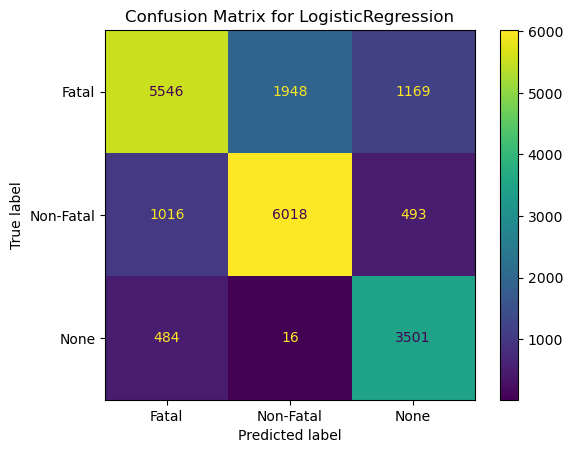

In [60]:
print_evaluation_metrics(metrics_lr, cm_lr, params, lr)

Training a random forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
metrics_rf, cm_rf, params, grid = optimiseGridSearch(rf)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 3/5] END .....max_depth=5, n_estimators=100;, score=0.725 total time=   4.1s
[CV 5/5] END .....max_depth=5, n_estimators=100;, score=0.729 total time=   4.1s
[CV 4/5] END .....max_depth=5, n_estimators=100;, score=0.754 total time=   4.2s
[CV 1/5] END .....max_depth=5, n_estimators=100;, score=0.742 total time=   4.2s
[CV 2/5] END .....max_depth=5, n_estimators=100;, score=0.738 total time=   4.2s
[CV 3/5] END .....max_depth=5, n_estimators=200;, score=0.727 total time=   8.3s
[CV 2/5] END .....max_depth=5, n_estimators=200;, score=0.733 total time=   8.4s
[CV 1/5] END .....max_depth=5, n_estimators=200;, score=0.732 total time=   8.5s
[CV 4/5] END .....max_depth=5, n_estimators=200;, score=0.752 total time=   8.9s
[CV 5/5] END .....max_depth=5, n_estimators=200;, score=0.730 total time=   9.0s
[CV 1/5] END ....max_depth=10, n_estimators=100;, score=0.762 total time=   7.1s
[CV 2/5] END ....max_depth=10, n_estimators=100;,

The best hyper-parameters mostly appear to be max_depth = 10, n_estimaros = 100-500

The F1 score of 0.7579 shows a good performance, similar to LR. <br>
The accuracy shows that the model correctly predicts ~76% of cases. <br>
Low standard deviations (0.0034 - 0.0039) show that the model is very stable across folds. <br>

The strong diagonal values on the confusion matrix indicate good classification. The main confusion areas are the 1780 "fatal" cases misclassified as "non-fatal" and 967 "fatal" cases misclassified as "none". The misclassifications are lower than with LR.

Performance for individual classes: <br>
Fatal - better recall than LR, fewer misclassifications" <br>
Non-Fatal - similar performance to LR, strong classification <br>
None - excellent precision, very few misclassifications as "non-fatal"

The selected best hyperparameters show a consistent selection of forest depth of 10, but the number of estimators varied between 100-500, suggesting medium complexity is optimal. More trees (higher number of estimators) generally perform better.

Overall Performance:
Average F1 score: 0.7579 (STD: 0.0039)
Average Accuracy: 0.7594370473546569 (STD: 0.0037)
Average Precision: 0.7654411455021503 (STD: 0.0034)
Average Recall: 0.7594370473546569 (STD: 0.0037)

Best hyper-parameters:
[{'max_depth': 10, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 500}, {'max_depth': 10, 'n_estimators': 500}, {'max_depth': 10, 'n_estimators': 200}, {'max_depth': 10, 'n_estimators': 500}]

Confusion Matrix:
[[5916 1780  967]
 [ 973 6038  516]
 [ 503   20 3478]]


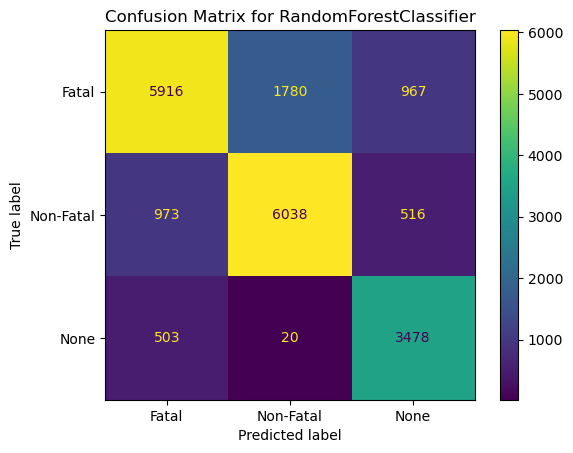

In [62]:
print_evaluation_metrics(metrics_rf, cm_rf, params, rf)

The most important feature in determining the injury severity for random forest was TAKEN_TO_HOSPITAL. This makes more sense than RACE (which was number one at the beginning), as TAKEN_TO_HOSPITAL is balanced and contains relevant and valuable information for the model. Also, it makes sense for the injury severity to be directly correlated with the likelihood of being taken to a hospital.

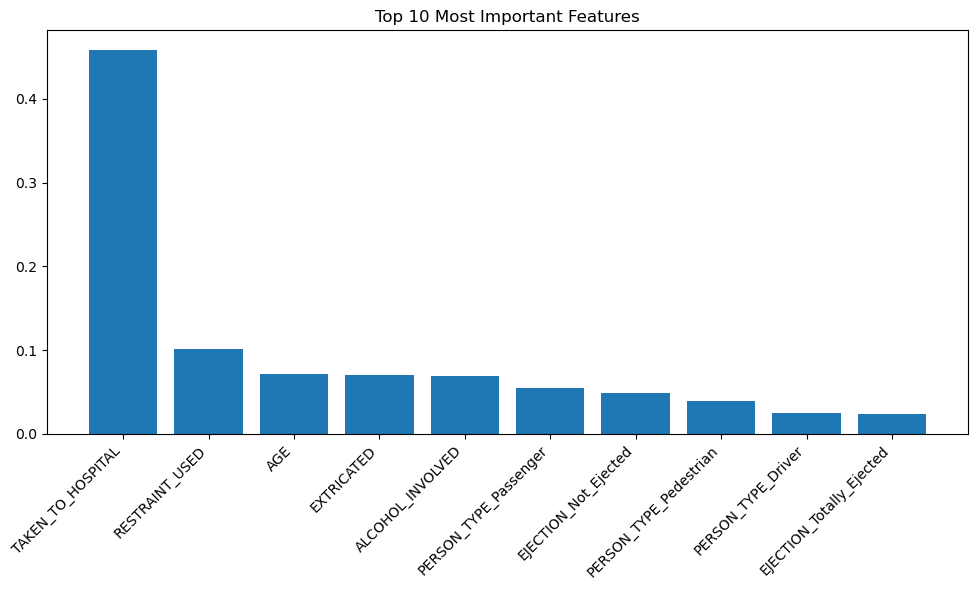

In [63]:
print_feature_importance(grid)

Comparison of the results:

| Pipeline | F1 Score | Accuracy | Precision | Recall |
| -------- | -------- | -------- | --------- | ------ |
| Logistic Regression | 0.7431 | 0.7458 | 0.7539 | 0.7458 |
| Random Forest | 0.7579 | 0.7594 | 0.7654 | 0.7594 |

The performance of the two models is very similar, which shows that both are capturing similar underlying patterns. This can be likely attributed to the balanced classes after preprocessing and clear decision boundaries between classes on key features. The simplification of many variables (converting to binary) makes the problem more linear. Therefore, linear boundaries might be sufficient, hence LR performs similarly to RF.

There can be many potential reasons for not achieving higher scores. This can include information loss during preprocessing, complex relationships that were not captured, or any external factors that are not present in the data.